In [1]:
# include path ../src in order to import modules
import sys
sys.path.append('../TCT')
import TCT as TCT
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# Step1: List all the APIs in the translator system
Translator_KP_info,APInames= TCT.get_SmartAPI_Translator_KP_info()
Translator_KP_info.to_csv('SmartAPI_Translator_KP_info.csv', index=False)
print(len(Translator_KP_info))

Skipping server without x-maturity: {'description': 'Production server', 'url': 'https://smart-api.info/api'}
Skipping server without x-maturity: {'description': 'Development server', 'url': 'https://dev.smart-api.info/api'}
SmartAPI API
Skipping server without production, staging or testing: {'description': 'Development server', 'url': 'https://dev.smart-api.info/api'}
Skipping server without x-maturity: {'description': 'Staging server', 'url': 'http://biothings.test.transltr.io/annotator'}
Skipping server without x-maturity: {'description': 'CI server', 'url': 'http://biothings.ci.transltr.io/annotator'}
99


In [3]:
# Step 2: Get metaKG from Translator APIs
metaKG = TCT.get_KP_metadata(APInames) # This only applies to the Translator APIs
print(metaKG.columns)
print(metaKG.shape)

Index(['API', 'KG_category', 'Subject', 'Object', 'URL'], dtype='object')
(12798, 5)


In [4]:
# add  new APIs to the list
#APInames['ctkp'] = 'https://multiomics.rtx.ai:9990/ctkp/meta_knowledge_graph'
#APInames['mokp'] = 'https://multiomics.rtx.ai:9990/mokp'
#APInames['dakp'] = 'https://multiomics.rtx.ai:9990/dakp'
#APInames['mbkp'] = 'https://multiomics.rtx.ai:9990/mbkp'
#APInames['CATRAX-PharmacogenomicsKG'] = 'https://multiomics.rtx.ai:9990/PharmacogenomicsKG'
APInames['BigGIM'] ="https://multiomics.rtx.ai:9990/BigGIM_DrugResponse_PerformancePhase"

In [4]:
# Step 3 (optional): add new metaKG from a user defined API
import requests
url = 'https://multiomics.rtx.ai:9990/ctkp/meta_knowledge_graph'
response = requests.get(url)
data = response.json()

for i in range(len(data["edges"])):
    APInames, metaKG = TCT.add_new_API_for_query(APInames, metaKG, "CTKP", "https://multiomics.rtx.ai:9990/ctkp/query", data["edges"][i]['predicate'], data["edges"][i]['subject'], data["edges"][i]['object'])


url = 'https://multiomics.rtx.ai:9990/dakp/meta_knowledge_graph'
response = requests.get(url)
data = response.json()
for i in range(len(data["edges"])):
    APInames, metaKG = TCT.add_new_API_for_query(APInames, metaKG, "DAKP", "https://multiomics.rtx.ai:9990/dakp/query", data["edges"][i]['predicate'], data["edges"][i]['subject'], data["edges"][i]['object'])

url = 'https://multiomics.rtx.ai:9990/BigGIM_DrugResponse_PerformancePhase/meta_knowledge_graph'
response = requests.get(url)
data = response.json()
for i in range(len(data["edges"])):
    APInames, metaKG = TCT.add_new_API_for_query(APInames, metaKG, "BigGIM", "https://multiomics.rtx.ai:9990/BigGIM_DrugResponse_PerformancePhase/query", data["edges"][i]['predicate'], data["edges"][i]['subject'], data["edges"][i]['object'])

url = 'https://multiomics.rtx.ai:9990/PharmacogenomicsKG/meta_knowledge_graph'
response = requests.get(url)
data = response.json()
for i in range(len(data["edges"])):
    APInames, metaKG = TCT.add_new_API_for_query(APInames, metaKG, "PharmacogenomicsKG", "https://multiomics.rtx.ai:9990/PharmacogenomicsKG/query", data["edges"][i]['predicate'], data["edges"][i]['subject'], data["edges"][i]['object'])
# Step 4: Save the metaKG to a file
metaKG.to_csv('../metaData/metaKG.csv', index=False)


In [6]:
metaKG.loc[metaKG['API']=="PharmacogenomicsKG"].to_csv('../metaData/PharmacogenomicsKG_meta.csv', index=False)

In [5]:
# Step 3: set input parameters
# Test multiomics BigGIM Drug Response KP
# Node1 for query
input_node1 = 'B-cell'
input_node1_id = TCT.get_curie(input_node1)
print(input_node1_id)
input_node1_id = 'NCBIGene:2215'
input_node1_list = [input_node1_id]
input_node1_category = ['biolink:Gene','biolink:Protein'] # Node: this has to be in a format of biolink:xxx

#Node2 for query
input_node2_list = []
input_node2_category = ['biolink:Cell'] # Node: this has to be in a format of biolink:xxx
#input_node2_category = ['biolink:Gene']

# Get all predicates for the input node1 and node2, user can furter select the predicates among this list
sele_predicates = list(set(TCT.select_concept(sub_list=input_node1_category,
                                              obj_list=input_node2_category,
                                              metaKG=metaKG)))



print("all relevant predicates in Translator:")
print(sele_predicates)
# select predicates

# Get all APIs for the input node1 and node2, user can furter select the APIs among this list
sele_APIs = TCT.select_API(sub_list=input_node1_category,
                           obj_list=input_node2_category,
                           metaKG=metaKG)

print("all relevant APIs in Translator:")
print(sele_APIs)
print(len(sele_APIs))

# get API URLs
API_URLs = TCT.get_Translator_API_URL(sele_APIs, 
                                      APInames)

MONDO:0004948
all relevant predicates in Translator:
['biolink:associated_with_sensitivity_to', 'biolink:affected_by', 'biolink:produced_by', 'biolink:actively_involved_in', 'biolink:subclass_of', 'biolink:expressed_in', 'biolink:acts_upstream_of_or_within', 'biolink:located_in', 'biolink:causes', 'biolink:occurs_together_in_literature_with', 'biolink:associated_with_resistance_to', 'biolink:regulates', 'biolink:active_in', 'biolink:produces', 'biolink:has_participant', 'biolink:has_part', 'biolink:related_to', 'biolink:location_of', 'biolink:disrupted_by', 'biolink:occurs_in', 'biolink:disrupts', 'biolink:correlated_with', 'biolink:develops_from', 'biolink:affects', 'biolink:part_of', 'biolink:overlaps', 'biolink:expresses', 'biolink:interacts_with', 'biolink:directly_physically_interacts_with']
all relevant APIs in Translator:
['MolePro', 'Automat-cam-kp(Trapi v1.5.0)', 'Service Provider TRAPI', 'Text Mined Cooccurrence API', 'Multiomics BigGIM-DrugResponse KP API', 'Automat-reactome

In [6]:
# Step 4: Format query json
query_json = TCT.format_query_json(input_node1_list,  # a list of identifiers for input node1
                                   input_node2_list,  # it can be empty list if only want to query node1
                                   input_node1_category,  # a list of categories of input node1
                                   input_node2_category,  # a list of categories of input node2
                                   sele_predicates) # a list of predicates
query_json

{'message': {'query_graph': {'nodes': {'n0': {'ids': ['NCBIGene:2215'],
     'categories': ['biolink:Gene', 'biolink:Protein']},
    'n1': {'categories': ['biolink:Cell']}},
   'edges': {'e1': {'subject': 'n0',
     'object': 'n1',
     'predicates': ['biolink:associated_with_sensitivity_to',
      'biolink:affected_by',
      'biolink:produced_by',
      'biolink:actively_involved_in',
      'biolink:subclass_of',
      'biolink:expressed_in',
      'biolink:acts_upstream_of_or_within',
      'biolink:located_in',
      'biolink:causes',
      'biolink:occurs_together_in_literature_with',
      'biolink:associated_with_resistance_to',
      'biolink:regulates',
      'biolink:active_in',
      'biolink:produces',
      'biolink:has_participant',
      'biolink:has_part',
      'biolink:related_to',
      'biolink:location_of',
      'biolink:disrupted_by',
      'biolink:occurs_in',
      'biolink:disrupts',
      'biolink:correlated_with',
      'biolink:develops_from',
      'biolin

In [7]:

# Step 5: Query Translator APIs and parse results
result = TCT.parallel_api_query(API_URLs,query_json=query_json, max_workers=len(API_URLs))

# Step 6: Parse results
result_parsed = TCT.parse_KG(result)

# Step 7: Ranking the results. This ranking method is based on the number of unique primary infores. It can only be used to rank the results with one defined node.
result_ranked_by_primary_infores = TCT.rank_by_primary_infores(result_parsed, input_node1_id)   # input_node1_id is the curie id of the input node, such as "NCBIGene:1017"


Warning Code:404:https://molepro-trapi.transltr.io/molepro/trapi/v1.5/query/
Warning Code:400:https://multiomics.rtx.ai:9990/BigGIM_DrugResponse_PerformancePhase/query
Warning Code:400:https://biothings.ncats.io/semmeddb/query/
Warning Code:400:https://biothings.ncats.io/annotator/query/
Warning Code:400:https://biothings.ncats.io/biggim_drugresponse_kp/query/
Success!https://automat.transltr.io/reactome/query/
Success!https://automat.transltr.io/monarch-kg/query/
Success!https://automat.transltr.io/ubergraph/query/
Success!https://automat.transltr.io/robokopkg/query/
Success!https://automat.transltr.io/cam-kp/query/
Success!https://cooccurrence.ci.transltr.io/query/
Success!https://bte.transltr.io/v1/team/Service%20Provider/query/
Success!https://bte.transltr.io/v1/query/


In [8]:
print(len(result.keys()))
result[list(result.keys())[0]]

100


{'subject': 'NCBIGene:2215',
 'predicate': 'biolink:expressed_in',
 'object': 'CL:0002092',
 'sources': [{'resource_id': 'infores:bgee',
   'resource_role': 'primary_knowledge_source'},
  {'resource_id': 'infores:monarchinitiative',
   'resource_role': 'aggregator_knowledge_source',
   'upstream_resource_ids': ['infores:bgee']},
  {'resource_id': 'infores:automat-robokop',
   'resource_role': 'aggregator_knowledge_source',
   'upstream_resource_ids': ['infores:monarchinitiative']}],
 'attributes': [{'original_attribute_name': 'knowledge_level',
   'value': 'not_provided',
   'attribute_type_id': 'biolink:knowledge_level'},
  {'original_attribute_name': 'agent_type',
   'value': 'not_provided',
   'attribute_type_id': 'biolink:agent_type'}]}

[Text(0.5, 0, 'granulocyte'), Text(2.5, 0, 'T cell'), Text(4.5, 0, 'macrophage'), Text(6.5, 0, 'effector memory CD8-positive, alpha-beta T cell'), Text(8.5, 0, 'eosinophil'), Text(10.5, 0, 'dendritic cell, human'), Text(12.5, 0, 'intermediate monocyte'), Text(14.5, 0, 'monocyte-derived dendritic cell'), Text(16.5, 0, 'CD8-positive, alpha-beta T cell'), Text(18.5, 0, 'CD4-positive, alpha-beta cytotoxic T cell'), Text(20.5, 0, 'CD14-positive, CD16-positive monocyte'), Text(22.5, 0, 'classical monocyte'), Text(24.5, 0, 'dendritic cell'), Text(26.5, 0, 'myeloid cell'), Text(28.5, 0, 'mononuclear cell'), Text(30.5, 0, 'Monocytes'), Text(32.5, 0, 'mature neutrophil')]


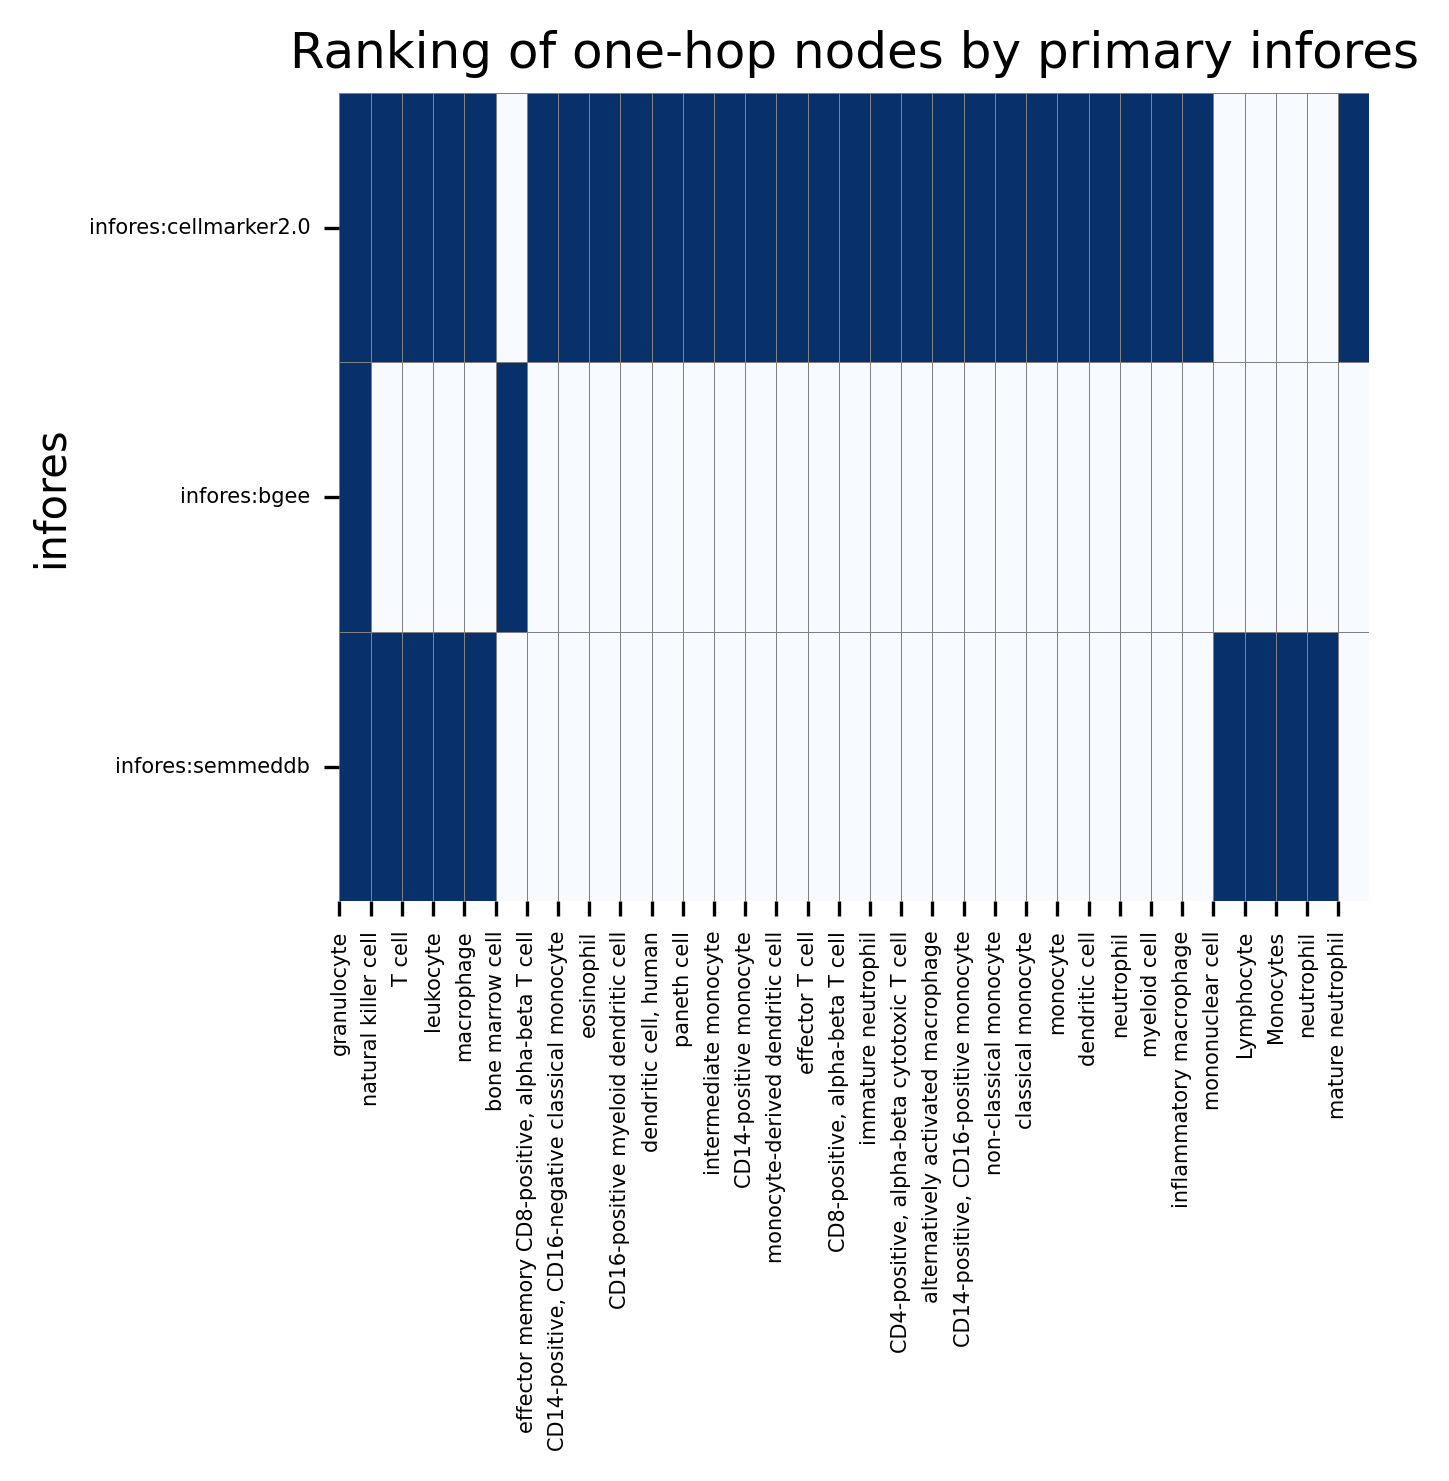

[Text(0.5, 0, 'granulocyte'), Text(2.5, 0, 'T cell'), Text(4.5, 0, 'macrophage'), Text(6.5, 0, 'effector memory CD8-positive, alpha-beta T cell'), Text(8.5, 0, 'eosinophil'), Text(10.5, 0, 'dendritic cell, human'), Text(12.5, 0, 'intermediate monocyte'), Text(14.5, 0, 'monocyte-derived dendritic cell'), Text(16.5, 0, 'CD8-positive, alpha-beta T cell'), Text(18.5, 0, 'CD4-positive, alpha-beta cytotoxic T cell'), Text(20.5, 0, 'CD14-positive, CD16-positive monocyte'), Text(22.5, 0, 'classical monocyte'), Text(24.5, 0, 'dendritic cell'), Text(26.5, 0, 'myeloid cell'), Text(28.5, 0, 'mononuclear cell'), Text(30.5, 0, 'Monocytes'), Text(32.5, 0, 'mature neutrophil')]


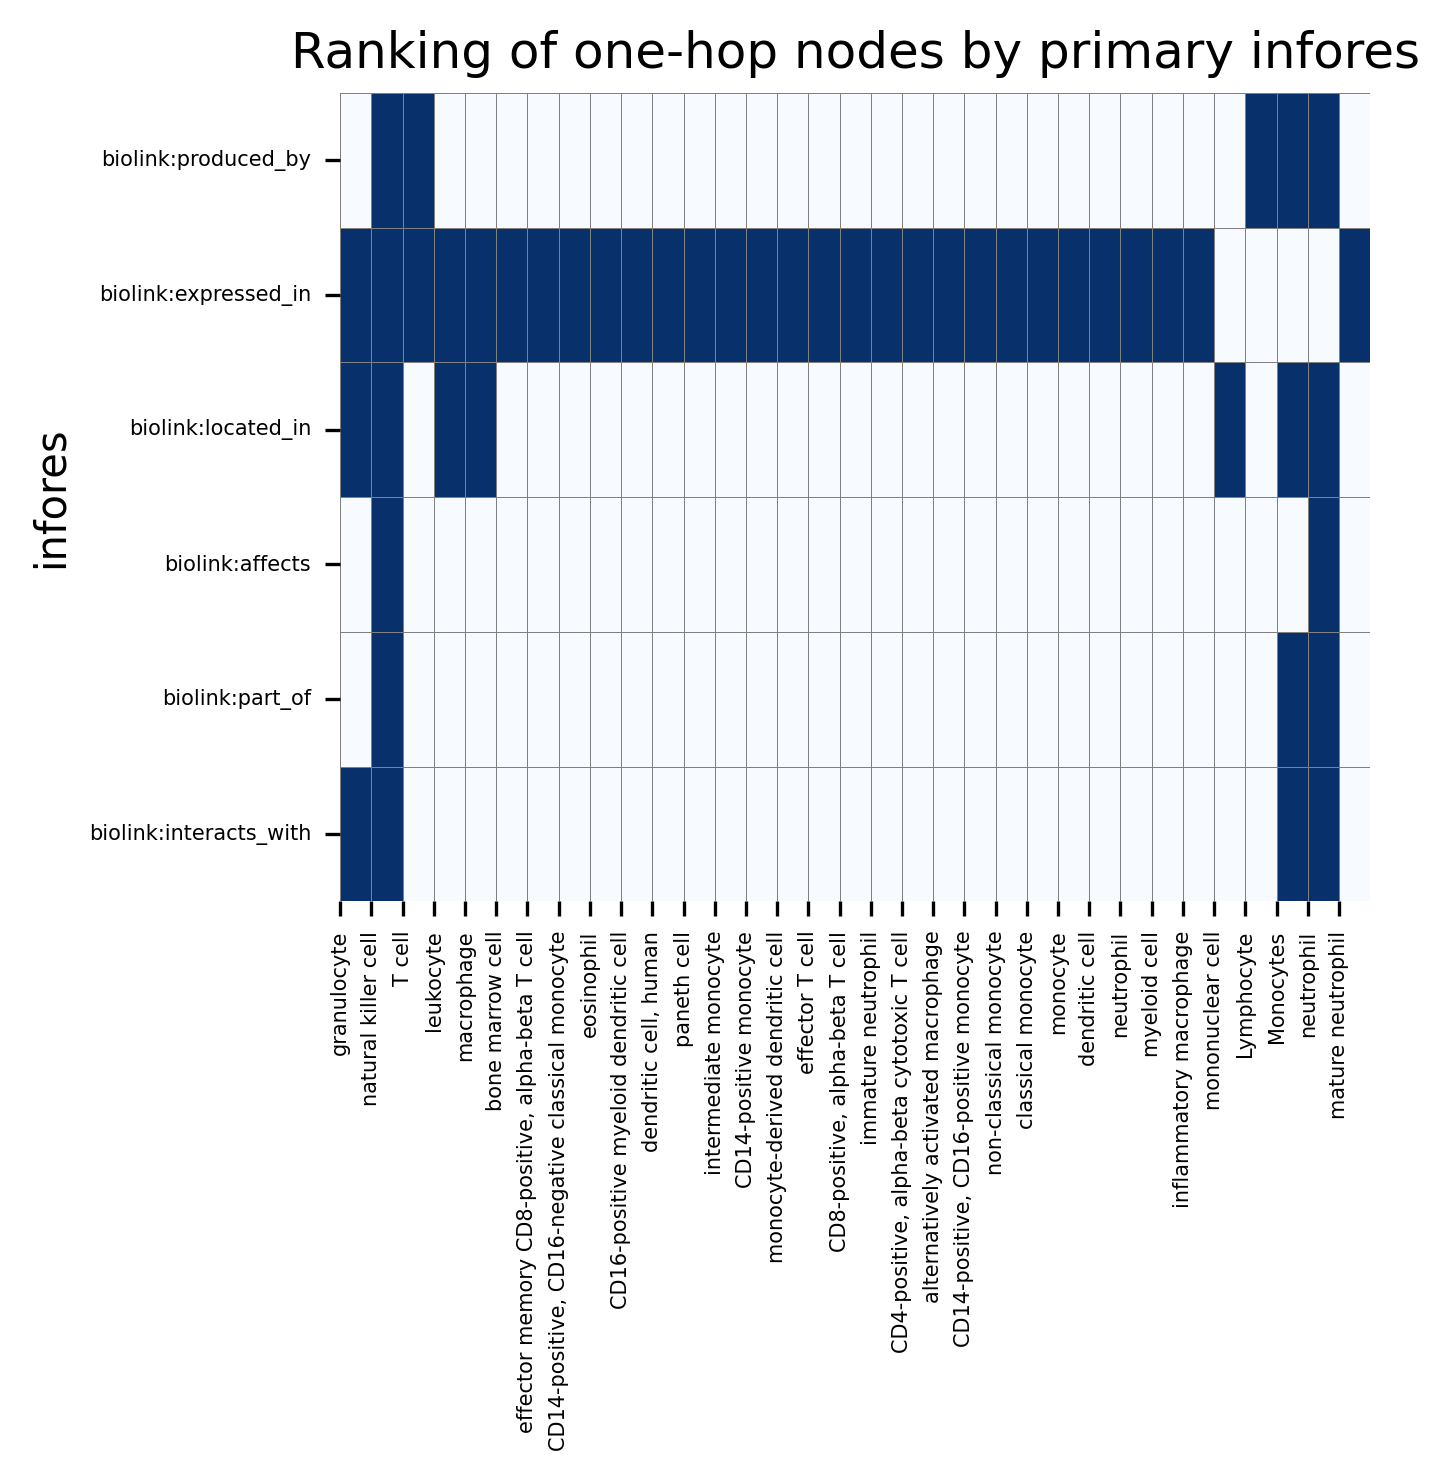

,granulocyte,natural killer cell,T cell,leukocyte,macrophage,bone marrow cell,"effector memory CD8-positive, alpha-beta T cell","CD14-positive, CD16-negative classical monocyte",eosinophil,CD16-positive myeloid dendritic cell,...,monocyte,dendritic cell,neutrophil,myeloid cell,inflammatory macrophage,mononuclear cell,Lymphocyte,Monocytes,neutrophil,mature neutrophil
biolink:produced_by,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1,0
biolink:expressed_in,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,1
biolink:located_in,1,1,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,0
biolink:affects,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
biolink:part_of,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
biolink:interacts_with,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


In [9]:
# Step 8: Visualize the results
TCT.visulization_one_hop_ranking(result_ranked_by_primary_infores, result_parsed, 
                                num_of_nodes = 50, input_query = input_node1_id, 
                                fontsize = 5)